In [21]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
hprice = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [27]:
hprice = pd.concat([hprice,pd.get_dummies(hprice.street, drop_first=True)], axis=1)

dummy_columns = list(pd.get_dummies(hprice.street, drop_first=True).columns)

hprice[['overallqual', 'overallcond', 'grlivarea'] + dummy_columns].head()

,overallqual,overallcond,grlivarea,Pave
0,7,5,1710,1
1,6,8,1262,1
2,7,5,1786,1
3,7,5,1717,1
4,8,5,2198,1


In [4]:
X = hprice[['overallqual', 'overallcond', 'grlivarea'] + dummy_columns]
Y = hprice['saleprice']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [12]:
X_train = sm.add_constant(X_train)

In [13]:
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     728.9
Date:                Tue, 19 Nov 2019   Prob (F-statistic):          5.42e-315
Time:                        09:59:40   Log-Likelihood:                -14093.
No. Observations:                1168   AIC:                         2.820e+04
Df Residuals:                    1163   BIC:                         2.822e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.303e+04   2.02e+04     -4.119      

The R-squared and the adjusted R-squared of the model are 0.715 and 0.714 respectively. Hence, according to the R-squared, around 28.6% of the variance in the target variable is unexplained by the model. AIC and BIC scores are 28200 and 28220 respectively.

Now, let's evaluate the test set performance:

In [17]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

y_preds.head()

135     154343.551135
1100    -15821.397295
833     177499.446272
471     244070.144632
1123    102266.813030
dtype: float64

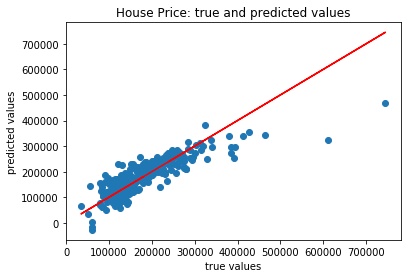

Mean absolute error of the prediction is: 30480.85978818593
Mean squared error of the prediction is: 1951062734.4281216
Root mean squared error of the prediction is: 44170.83579046384
Mean absolute percentage error of the prediction is: 19.40110259650507


In [22]:
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House Price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



The performance of your model looks to be satisfactory. To check if we can get a better result we try another model specification and compare this two models:

In [28]:
hprice['totalsf'] = hprice['totalbsmtsf'] + hprice['firstflrsf'] + hprice['secondflrsf']

hprice['int_over_sf'] = hprice['totalsf'] * hprice['overallqual']

# Y is the target variable
Y = hprice['saleprice']
# X is the feature set
X = hprice[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + dummy_columns]



In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     536.5
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:25:12   Log-Likelihood:                -13982.
No. Observations:                1168   AIC:                         2.798e+04
Df Residuals:                    1160   BIC:                         2.802e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.098e+04   2.16e+04     -1.901      

This second model's R-squared and adjusted R-squared values are higher and AIC and BIC criterias are lower than the first model. In any case, these indicate that the second model has a better goodness of fit than the first model. Now, let's evaluate the test set performance of this second model:

In [32]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

y_preds.head()

135     171125.271208
1100     23595.847513
833     190944.673128
471     242021.672227
1123     77698.143168
dtype: float64

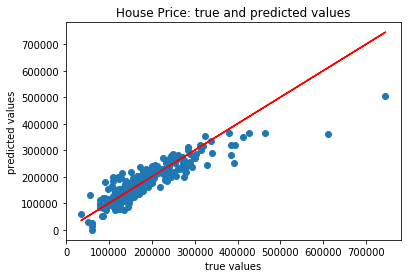

Mean absolute error of the prediction is: 24698.238598024665
Mean squared error of the prediction is: 1388988758.1609251
Root mean squared error of the prediction is: 37269.139487797744
Mean absolute percentage error of the prediction is: 15.094458323175786


In [33]:
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House Price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



Since we get lower values in the test set evaluation metrics, the second model achieves a better prediction performance in the test set.